In [66]:
from matplotlib import pyplot as plt
import numpy as np

np.random.seed(142)

In [67]:
# Global variables from the constants table, all in GeV^-2.
M_z = 91.188
Gamma_z = 2.4414
alpha = 1 / 132.507
G_f = 1.16639e-5
W_angle_2 = 0.222246

Q_e = Q_mu = -1
V_e = V_mu = -0.5 + 2 * W_angle_2
A_e = A_mu = -0.5

kappa = np.sqrt(2) * G_f * M_z ** 2 / (4 * np.pi * alpha)

In [68]:
# Function for the differential cross section for center-of-mass energy and scattering angle.
def diff_cross_section(energy, theta):
    s_hat = energy ** 2
    coeff = alpha ** 2 / (4 * s_hat)
    return 2 * np.pi * coeff * (A_0(s_hat) * (1 + np.cos(theta) ** 2) + A_1(s_hat) * np.cos(theta))

def A_0(s_hat):
    return Q_e ** 2 - 2 * Q_e * V_mu * V_e * X_1(s_hat) + (A_mu ** 2 + V_mu ** 2) * (A_e ** 2 + V_e ** 2) * X_2(s_hat)

def A_1(s_hat):
    return -4 * Q_e * A_mu * A_e * X_1(s_hat) + 8 * A_mu * V_mu * A_e * V_e * X_2(s_hat)

def X_1(s_hat):
    return kappa * s_hat * (s_hat - M_z ** 2) / ((s_hat - M_z ** 2) ** 2 + Gamma_z ** 2 * M_z ** 2)

def X_2(s_hat):
    return kappa ** 2 * s_hat ** 2 / ((s_hat - M_z ** 2) ** 2 + Gamma_z ** 2 * M_z ** 2)

In [69]:
# My function to map uniform samples to the problem domain.
def map_to_domain(x, y):
    # E_cm = [10, 200] and cos(theta) = [-1, 1].
    s_hat = 10 + 190 * x
    cos_theta = -1 + 2 * y

    return (s_hat, np.arccos(cos_theta))

# VEGAS-plus includes grid sampling to reduce variance.
def adapt_grid(f_values, old_grid, alpha=1.5, epsilon=1e-8, rho=0.03):
    f_values += epsilon
    f_values **= alpha
    f_values /= np.sum(f_values)

    cum_values = np.cumsum(f_values)
    cum_values = np.insert(cum_values, 0, 0)

    # Divide domain into regions based on the cumulative values.
    new_grid = np.interp(np.linspace(0, 1, len(old_grid)), cum_values, old_grid)
    return rho * new_grid + (1 - rho) * old_grid

In [70]:
# Parameters.
i_bins, bins = 100, 200
iters = 500
samples = 2000

x_grid, y_grid = np.linspace(0, 1, i_bins + 1), np.linspace(0, 1, i_bins + 1)
estimations = []

for i in range(iters):
    sum_f = np.zeros((i_bins, i_bins))
    estimation = 0

    for _ in range(samples):
        # Sampling random positions.
        xi = np.random.randint(i_bins)
        yi = np.random.randint(i_bins)
        x = np.random.uniform(x_grid[xi], x_grid[xi + 1])
        y = np.random.uniform(y_grid[yi], y_grid[yi + 1])

        # Map the position to acceptable s and theta.
        s_hat, theta = map_to_domain(x, y)
        f = diff_cross_section(s_hat, theta)

        # Add the estimated integral along with the grid location for adaptive sampling.
        estimation += f
        sum_f[xi, yi] += f

    estimation /= samples
    estimations.append(estimation)

    if i % 50 == 0:
        print(f"Iteration {i + 1}, Integral Estimate: {estimation}")

    # In plus version, we update the grid position with an grid adaptation method.
    sum_f /= np.sum(sum_f)
    x_grid = adapt_grid(np.sum(sum_f, axis=1), x_grid)
    y_grid = adapt_grid(np.sum(sum_f, axis=0), y_grid)

Iteration 1, Integral Estimate: 1.0081332507808072e-07
Iteration 51, Integral Estimate: 2.5264154627868587e-07
Iteration 101, Integral Estimate: 5.529027357516459e-07
Iteration 151, Integral Estimate: 9.089285724923598e-07
Iteration 201, Integral Estimate: 1.1295169416098462e-06
Iteration 251, Integral Estimate: 1.2593601948124666e-06
Iteration 301, Integral Estimate: 1.7683071134591619e-06
Iteration 351, Integral Estimate: 2.3985847166241225e-06
Iteration 401, Integral Estimate: 2.910380648677238e-06
Iteration 451, Integral Estimate: 3.2629195223593753e-06


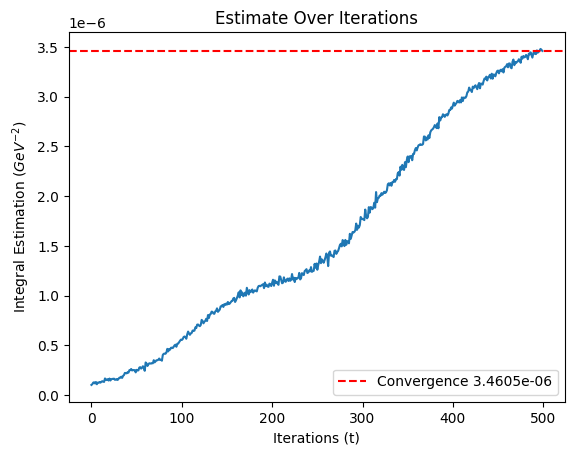

In [71]:
plt.plot(np.arange(iters), estimations)
plt.xlabel(r'Iterations (t)')
plt.ylabel(r'Integral Estimation $(GeV^{-2})$')
plt.title('Estimate Over Iterations')
plt.axhline(y=estimations[-1], color='r', linestyle='--', label=f'Convergence {round(estimations[-1], 10)}')
plt.legend()
plt.show()

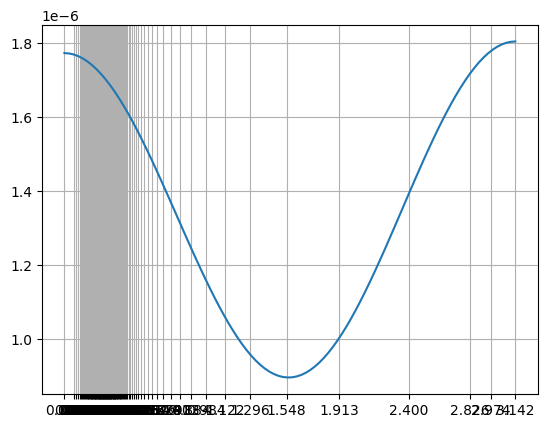

In [72]:
theta_low = np.arccos(-1 + 2 * y_grid)

x = np.linspace(0, np.pi, 100)
fig, ax = plt.subplots()
E_c = 10

plt.plot(x, diff_cross_section(E_c, x))
plt.xticks(theta_low)
plt.grid(True)
plt.show()

In [73]:
s_hat_samples, theta_samples = [], []
n_samples = 1_000_000

for _ in range(n_samples):
    # Sampling random positions.
    xi = np.random.randint(i_bins)
    yi = np.random.randint(i_bins)
    x = np.random.uniform(x_grid[xi], x_grid[xi + 1])
    y = np.random.uniform(y_grid[yi], y_grid[yi + 1])

    # Map the position to acceptable s and theta.
    s_hat, theta = map_to_domain(x, y)
    s_hat_samples.append(s_hat)
    theta_samples.append(theta)

theta_samples = np.cos(theta_samples)

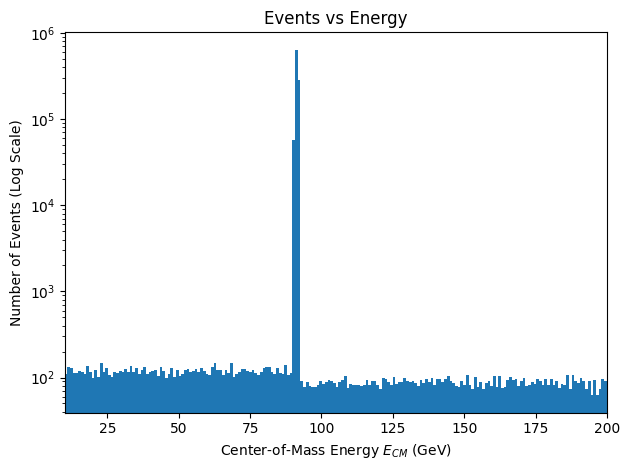

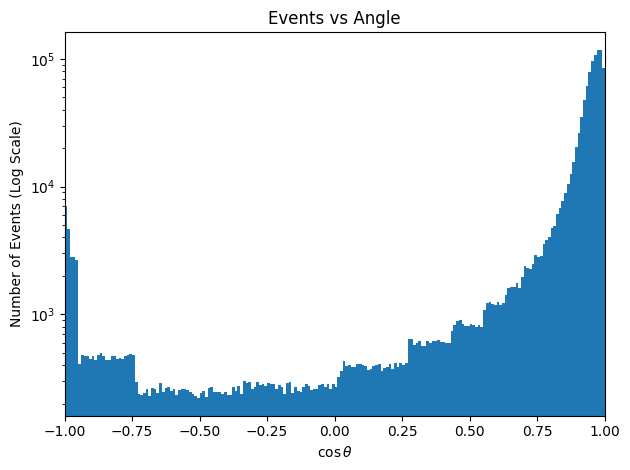

In [74]:
# Histogram of number of sampled events vs CM energy.
plt.hist(s_hat_samples, bins=bins)
plt.xlim(10, 200)
plt.xlabel(r'Center-of-Mass Energy $E_{CM}$ (GeV)')
plt.ylabel('Number of Events (Log Scale)')
plt.title('Events vs Energy')
plt.yscale('log')

plt.tight_layout()
plt.savefig("plots/vegas-plus-energy.png")
plt.show()

# Histogram of number of sampled events vs scattering angle.
plt.hist(theta_samples, bins=bins)
plt.xlim(-1, 1)
plt.xlabel(r'$\cos \theta$')
plt.ylabel('Number of Events (Log Scale)')
plt.title('Events vs Angle')
plt.yscale('log')

plt.tight_layout()
plt.savefig("plots/vegas-plus-theta.png")
plt.show()

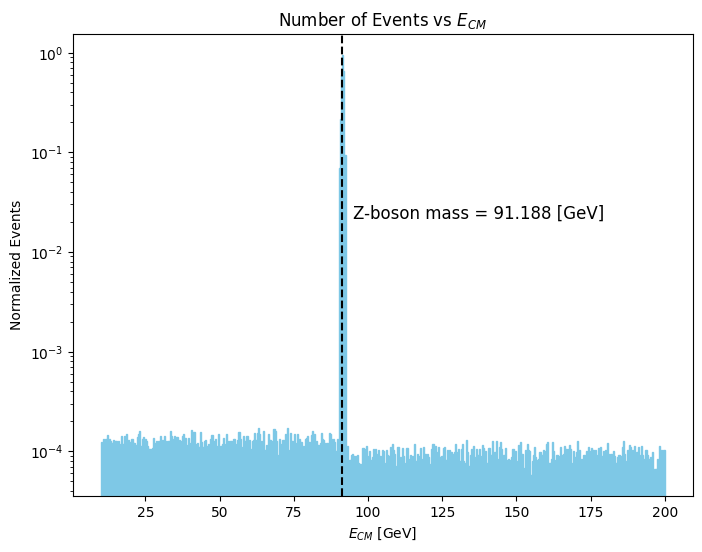

In [80]:
energy_values = s_hat_samples

# Plot 
plt.figure(figsize=(8, 6))
plt.hist(energy_values, bins=500, color='#7EC8E6', edgecolor='#7EC8E6', density=True)
plt.xlabel("$E_{CM}$ [GeV]")
plt.ylabel("Normalized Events")
plt.title("Number of Events vs $E_{CM}$")
plt.axvline(x=91.188, color='black', linestyle='--')
plt.text(95, 0.02, "Z-boson mass = 91.188 [GeV]", color='black', fontsize=12, verticalalignment='bottom')
plt.yscale('log')
plt.savefig("plots/vegas_plus.png")

plt.show()

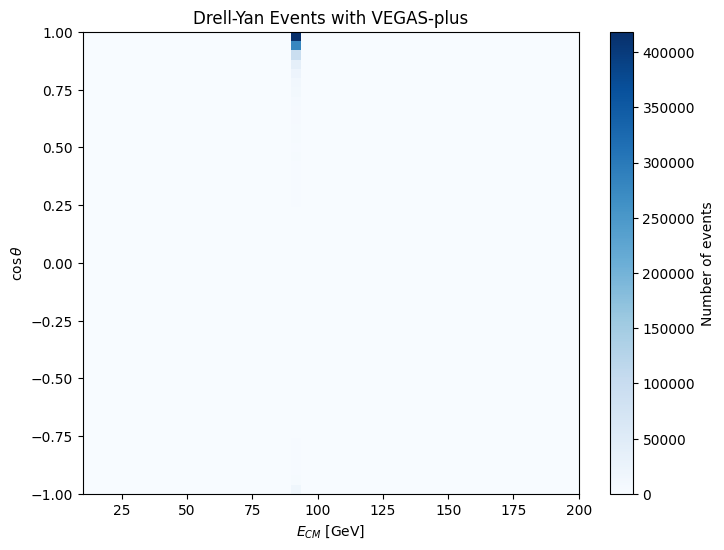

In [75]:
# Heat map of events, code from Ellison.
plt.figure(figsize=(8,6))
plt.hist2d(s_hat_samples, theta_samples, bins=50, cmap='Blues')
plt.colorbar(label="Number of events")
plt.xlim(10, 200)
plt.ylim(-1, 1)
plt.xlabel("$E_{CM}$ [GeV]")
plt.ylabel(r"$\cos \theta$")
plt.title("Drell-Yan Events with VEGAS-plus")
plt.savefig("plots/vegas-plus-heatmap.png")
plt.show()

[1.16158799e-01 1.17421646e+02 9.14499825e+01 4.03190360e-03]


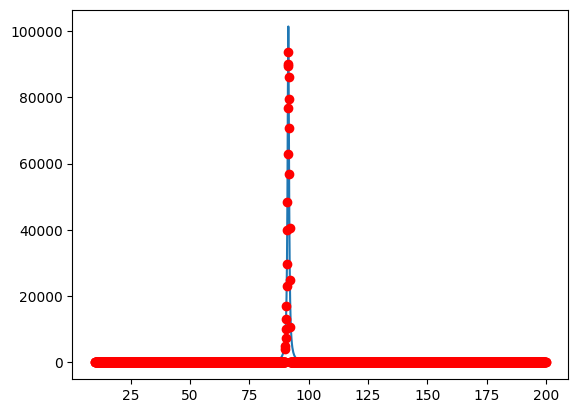

In [76]:
from scipy.optimize import curve_fit

def cross_section(E, z1, z2, M, Gamma):
    return z1**2/((E**2)) + z2**2/((E - M)**2 + (M*Gamma)**2)

E0 = plt.hist(s_hat_samples, bins=2000)
plt.cla()

sigma, E1, container = E0
E1 = E1[:-1]

popt, pcov = curve_fit(cross_section, E1, sigma, p0 = (500_000, 500_000, 90, 10), bounds = (0, [np.inf, np.inf, 100, 20]))
print(popt)
x = np.linspace(np.min(E1), np.max(E1), 1001)
plt.plot(x, cross_section(x, *popt))
plt.plot(E1, sigma, 'ro')
plt.show()

In [77]:
Gamma = popt[-1] * 1e9
t = 6.582e-16 / Gamma
print("lifetime of z-boson:", t, "s")

lifetime of z-boson: 1.6324795050481948e-22 s
